In [1]:
import pickle
import pandas as pd
import numpy as np
import re
import string
import unidecode
from collections import defaultdict
from keras.models import Sequential, Model
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Embedding, concatenate, Input, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from nltk import word_tokenize
from nltk.corpus import stopwords

Using TensorFlow backend.


In [2]:
with open("../data/word2idx/word2idx.pkl", "rb") as f:
    word2idx = pickle.load(f)
    #Map any unknown word to UNKNOWN, which has index 1

In [3]:
len(word2idx)

445881

In [4]:
data = pd.read_csv('../data/sample_data_1percent.csv')

In [5]:
data.head()

,text,link_anchor,link_start,link_end,target_wikidata,tokenized_vector,candidates
0,the academy awards also officially and popular...,film industry,120,133,1415395,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[93196.0, 2973146.0, 2973208.0, 2973157.0, 328..."
1,the academy awards also officially and popular...,academy of motion picture arts and sciences,156,199,212329,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[212329.0, 212329.0]"
2,the academy awards also officially and popular...,art deco,551,559,173782,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[173782.0, 4824850.0, 4796770.0, 23307613.0, 2..."
3,the academy awards also officially and popular...,george stanley,603,617,5544783,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[3101928.0, 5539480.0, 5544780.0, 5544779.0, 5..."
4,the academy awards also officially and popular...,cedric gibbons,642,656,727904,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[727904.0, 5057103.0]"


In [6]:
data.iloc[0]['candidates']

'[93196.0, 2973146.0, 2973208.0, 2973157.0, 328799.0, 380675.0, 1198185.0, 1415395.0, 646116.0, 15956340.0, 5120804.0, 11424.0, 21065894.0]'

In [265]:
with open('../data/sample_doc2vec_data.pkl', 'rb') as f:
    docs = pickle.load(f)

In [223]:
with open('../data/sample_labels.pkl', 'rb') as f:
    data = pickle.load(f)

In [224]:
with open('../data/knowledge_graph_data/id2text_entity.pickle', 'rb') as f:
    id2text = pickle.load(f)

In [225]:
with open('../data/name_to_wiki_id.pkl', 'rb') as f:
    name_to_wiki_id = pickle.load(f)

In [226]:
with open('../data/knowledge_graph_data/idx2id_entity.pickle', 'rb') as f:
    idx2id = pickle.load(f)

In [227]:
id2idx = {value: key for key, value in idx2id.items()}

In [228]:
graph_embedding = np.load('../data/knowledge_graph_data/wiki_DistMult_entity.npy') 

In [229]:
# replace words within paranthesis and remove non alphanumeric characters
# get_rid of `the` which can cause difference
pattern = re.compile(r'\([^)]*\)|[^a-zA-Z0-9 -]|\s|(^|[^a-zA-Z0-9])the[^a-zA-Z0-9]')
# unidecode to remove accents
normalize_text = lambda text: pattern.sub("", unidecode.unidecode(text).lower())


In [230]:
#window length actually 2 times this since from both sides
window_length = 10

In [269]:
#For each of the entities in each of the rows, make word2idx vector using context window and also get graph embedding.

lstm_input = []
graph_input = []
doc_input = []
response = []
not_in_graph = []
for i, article in enumerate(data):
    text = article[0]
    doc_embedding = docs[i][0]
    for entity, indices in article[1].items():
        name = entity[0]
        entity_id = entity[3]
        #Don't include actual entity text for now in context window since doing fixed length? 
        entity_idx = np.where(indices == 1)[0]
        split_text = text.split()
        context = split_text[max(0, entity_idx.min() - window_length) : entity_idx.min()] +\
                  split_text[entity_idx.max() + 1 : entity_idx.max() + window_length + 1] 
        #if word not in vocab, by default map to 1
        context_word2idx = [word2idx.get(word, 1) for word in context]
        #get a candidate from candidate_dict to get a false, irrelevant entity for each entity
        candidates_list = name_to_wiki_id[normalize_text(name)]
        #can't choose actual entity as false 
        if entity_id in candidates_list:
            candidates_list.remove(entity_id)
        if len(candidates_list) > 0:
            for false_entity_id in candidates_list:
                if false_entity_id in id2idx:
                    false_graph_embed = graph_embedding[id2idx[false_entity_id]]
                    lstm_input.append(context_word2idx)
                    graph_input.append(false_graph_embed)
                    doc_input.append(doc_embedding)
                    response.append(0)
                else:
                    not_in_graph.append(false_entity_id)
        if entity_id in id2idx:
            true_graph_embed = graph_embedding[id2idx[entity_id]]
            lstm_input.append(context_word2idx)
            graph_input.append(true_graph_embed)
            doc_input.append(doc_embedding)
            response.append(1)
        else:
            not_in_graph.append(entity_id)
            
lstm_input = pad_sequences(lstm_input, maxlen = window_length * 2, padding = 'post')
graph_input = np.array(graph_input)
doc_input = np.array(doc_input)
response = np.array(response)

In [270]:
len(doc_input)

106433

In [271]:
len(graph_input)

106433

In [272]:
len(lstm_input)

106433

In [273]:
len(response)

106433

In [274]:
len(doc_embedding)

1000

In [275]:
response.mean()

0.1976924450123552

In [276]:
len(not_in_graph)

4681

In [277]:
len(not_in_graph) / len(graph_input)

0.043980720265331244

In [279]:
train_ind, test_ind = train_test_split(np.arange(len(response)))
lstm_train = lstm_input[train_ind]
lstm_test = lstm_input[test_ind]
graph_train = graph_input[train_ind]
graph_test = graph_input[test_ind]
doc_train = doc_input[train_ind]
doc_test = doc_input[test_ind]
y_train = response[train_ind]
y_test = response[test_ind]

len(y_train), len(y_test)

(79824, 26609)

In [339]:
inp1 = Input(shape = (lstm_input.shape[1], ))
inp2 = Input(shape = (graph_input.shape[1], ))
inp3 = Input(shape = (doc_input.shape[1], ))
embed = Embedding(output_dim=100, input_dim=len(word2idx), input_length=lstm_input.shape[1])(inp1)
embed = Dropout(rate = 0.2)(embed)
out1 = LSTM(50)(embed)
w = concatenate([out1, inp2])
w = Dropout(0.2)(w)
out = Dense(1, activation = 'sigmoid')(w)
model = Model(inputs=[inp1, inp2], outputs=out)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_49 (InputLayer)           (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_33 (Embedding)        (None, 20, 100)      44588100    input_49[0][0]                   
__________________________________________________________________________________________________
dropout_15 (Dropout)            (None, 20, 100)      0           embedding_33[0][0]               
__________________________________________________________________________________________________
lstm_33 (LSTM)                  (None, 50)           30200       dropout_15[0][0]                 
__________________________________________________________________________________________________
input_50 (

In [340]:
# model.fit([lstm_train, graph_train, doc_train], y_train, batch_size = 256, epochs = 3, validation_split = 0.2)
model.fit([lstm_train, graph_train], y_train, batch_size = 256, epochs = 3, validation_split = 0.2)

Train on 63859 samples, validate on 15965 samples
Epoch 1/3
63859/63859 [==============================] - 81s 1ms/step - loss: 0.4289 - acc: 0.8091 - val_loss: 0.3585 - val_acc: 0.8393
Epoch 2/3
63859/63859 [==============================] - 79s 1ms/step - loss: 0.3079 - acc: 0.8650 - val_loss: 0.3223 - val_acc: 0.8595
Epoch 3/3
63859/63859 [==============================] - 79s 1ms/step - loss: 0.2552 - acc: 0.8945 - val_loss: 0.3168 - val_acc: 0.8628


In [345]:
# y_test_pred = model.predict([lstm_test, graph_test, doc_test])
y_test_pred = model.predict([lstm_test, graph_test])

y_test_pred = np.where(y_test_pred > 0.25, 1, 0)
accuracy_score(y_test, y_test_pred)

0.836183246270059

In [346]:
cm = confusion_matrix(y_test, y_test_pred)

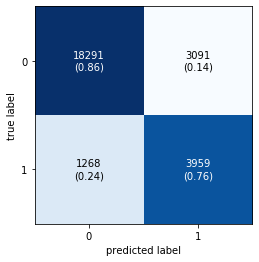

In [347]:
from mlxtend.plotting import plot_confusion_matrix

plot_confusion_matrix(cm, show_normed = True);